In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
# csv files for answer responses
gdrive_path = "/Users/dorislee/Google Drive/Turn/VAST/user_study/evaluation_study/transcription_and_analysis/"

In [4]:
user_task =  pd.read_csv(gdrive_path+"UserTaskAssignment.csv")

In [5]:
%load_ext autoreload
%autoreload 2
from paper_visualization import *

# Participant Demographics 

In [6]:
info = pd.read_csv(gdrive_path+"participant_information.csv")

In [7]:
data = ['Excel', 'Tableau', 'programming', 'SQL']

In [8]:
counts = []
for x in data:
    counts.append(len(info[info["DataAnalysisTool"].str.contains(x)]))

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/matplotlib/font_manager.py:1339: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


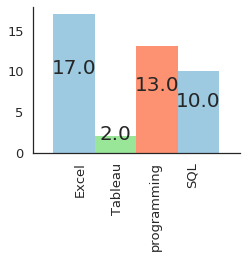

In [9]:
bar_chart(counts,data,fixed_ylim=False,rotation=90)

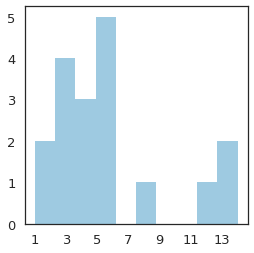

In [10]:
data = info["YearsExperience"]
ax = plt.hist(data,bins=10)
a = plt.xticks(np.arange(1,data.max(),2))

In [11]:
data.describe()

count    18.000000
mean      5.611111
std       3.775134
min       1.000000
25%       3.000000
50%       4.500000
75%       6.000000
max      14.000000
Name: YearsExperience, dtype: float64

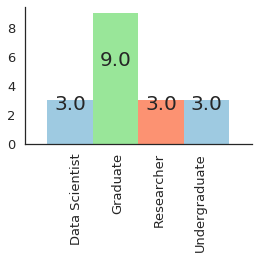

In [12]:
bar_chart(list(info.groupby("Position").count().reset_index()["Gender"]),list(info.groupby("Position").count().reset_index()["Position"]),fixed_ylim=False,rotation=90)

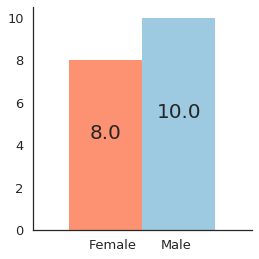

In [13]:
bar_chart(list(info.groupby("Gender").count().reset_index()["Position"]),list(info.groupby("Gender").count().reset_index()["Gender"]),fixed_ylim=False)

# Interested Retrieval

user_click_data.csv generated by running Parsing User Study Clickstream.ipynb

In [89]:
retreival = pd.read_csv(gdrive_path+"user_click_data.csv")

In [6]:
from tabulate import tabulate

In [7]:
import tabulate as T
del(T.LATEX_ESCAPE_RULES[u'\\'])

Equal weighting for interested + uninterested, 0 for no selection

In [8]:
def getDataset(x):
    if 'A' in x:
        return "Police"
    else:
        return "Autism"

In [9]:
retreival["dataset"]=retreival["task"].apply(getDataset)

In [10]:
retreival.loc[retreival["interested"]=="unselected","retreival score"]=0
retreival.loc[retreival["interested"]=="interested","retreival score"]=1
retreival.loc[retreival["interested"]=="not interested","retreival score"]=-1
# retreival score, the higher the better, kind of like a relevance score
relevance = retreival.groupby(["dataset","visualization"]).sum()["retreival score"].reset_index().rename(columns={"retreival score":"relevance score"})
retreival = retreival.merge(relevance)
retreival["result score"]=retreival["retreival score"]*retreival["relevance score"]

In [11]:
avrg_result = retreival.groupby(["dataset","task"]).sum()["result score"]

In [12]:
avrg_score_result = [["Police"]+list(avrg_result["Police"]),["Autism"]+list(avrg_result["Autism"])]

In [15]:
print T.tabulate(avrg_score_result,headers=['Dataset','\system','Cluster','BFS'],tablefmt='latex')

\begin{tabular}{lrrr}
\hline
 Dataset   &   \system &   Cluster &   BFS \\
\hline
 Police    &        62 &        52 &    99 \\
 Autism    &       213 &       180 &   114 \\
\hline
\end{tabular}


#### P@k, R@k: say that we only care about top-k retreival

In [16]:
def compute_average_PR_at_k_over_all_data(k):
    retreival["dataset"]=retreival["task"].apply(lambda x:x[0])#.groupby["ideal retreival score"]
    dedup_retreival=retreival[["dataset","visualization","ideal retreival score"]].drop_duplicates()
    
    # get top-k for dataset A and dataset B
    dedup_retreivalA=dedup_retreival[dedup_retreival["dataset"]=='A']
    topk_A = dedup_retreivalA.loc[dedup_retreivalA["ideal retreival score"].nlargest(k,"ideal retreival score").index]
    dedup_retreivalB=dedup_retreival[dedup_retreival["dataset"]=='B']
    topk_B = dedup_retreivalB.loc[dedup_retreivalB["ideal retreival score"].nlargest(k,"ideal retreival score").index]
    topk_A_lst =list(topk_A["visualization"])
    topk_B_lst =list(topk_B["visualization"])
    def compute_PR_at_k(user_id):
        selected_user = retreival[retreival["user"]==user_id]
        relevant = (selected_user["visualization"].isin(topk_A_lst)|selected_user["visualization"].isin(topk_B_lst))
        retreived = (selected_user["interested"]=="interested")
        Nrelevant_and_retreived = float(len(selected_user[(relevant)&(retreived)]))
        Nrelevant = len(selected_user[relevant])
        Nretreived = len(selected_user[retreived])
        if Nrelevant !=0 and Nretreived!=0:
            precision  = Nrelevant_and_retreived/Nrelevant
            recall = Nrelevant_and_retreived/Nretreived
            return precision,recall
        else:
            return 0,0
    # compute PR
    retreival["P@"+str(k)],retreival["R@"+str(k)] = zip(*retreival["user"].apply(compute_PR_at_k))
    return retreival.groupby("task",as_index=False)[["P@"+str(k),"R@"+str(k)]].mean()

In [18]:
# compute_average_PR_at_k_over_all_data(5)

# Ranking

In [19]:
def dcg(r, k, method=0):
    # alternative formulation of DCG places stronger emphasis on retrieving relevant documents
    r = np.asfarray(r)[:k]
    val = 0
    for i in range(1,len(r)):
        val+= (2**r[i]-1) / np.log2(i+1)
    return val

def ndcg(dcg_ground_truth,r, k):
    return dcg(r, k) / sum(dcg_ground_truth)

In [49]:
def compute_ndcg_rankings(user_ranking_filename,gt_ranking_filename):#,k_lst = [1,2,3,5,7]):

    user_rank = pd.read_csv(gdrive_path+user_ranking_filename)
    ground_truth_rank = pd.read_csv(gt_ranking_filename,index_col=0)
    k = len(ground_truth_rank["attribute"])
    ground_truth_cramerV_rank = list(ground_truth_rank["cramerV"].rank(ascending=False)) 
    #print ground_truth_cramerV_rank
    if "Police" in user_ranking_filename: 
        task_name = "Task1"
    else: 
        task_name = "Task2"
    #highest cramer's V corresponds to most correlated, corresponds to rank 1
    user_rank = user_rank.merge(user_task).drop("Note",axis=1)
    user_rankings=[]
    #Putting user rankings into appropriate data structures
    for row in user_rank.iterrows():
        ranking = []
        for attr in ground_truth_rank.attribute:
            ranking.append(row[1][attr])
        task = row[1][task_name]
        user_rankings.append([task,ranking])
    #Computing ndcg ranking
    ndcg_data = []
    for trial in user_rankings:
        ndcg_d = []
        #print trial
        ndcg_d.append(trial[0])
        #for k in k_lst:
        ndcg_d.append(ndcg(ground_truth_cramerV_rank,trial[1],k))
#             print trial[1]
        ndcg_data.append(ndcg_d)
#    print ndcg_data
    NDCG_lst = ["NDCG@"+str(k)]
    ndcg_result = pd.DataFrame(ndcg_data,columns=["Task"]+NDCG_lst)
    return ndcg_result.groupby("Task",as_index=False).mean()

In [50]:
ground_truth_rank = pd.read_csv("ct_police_ground_truth_correlation.csv")

In [51]:
ndcg_result=[["Police"]+list(compute_ndcg_rankings("Ranking(Police).csv","ct_police_ground_truth_correlation.csv")["NDCG@7"]),
["Autism"]+list(compute_ndcg_rankings("Ranking(Autism).csv","autism_ground_truth_correlation.csv")["NDCG@10"])]

In [53]:
print T.tabulate(ndcg_result,headers=['Dataset','\system','Cluster','BFS'],tablefmt='latex', floatfmt=".2f")

\begin{tabular}{lrrr}
\hline
 Dataset   &   \system &   Cluster &   BFS \\
\hline
 Police    &      0.63 &      0.45 &  0.84 \\
 Autism    &      0.50 &      0.35 &  0.24 \\
\hline
\end{tabular}


- NDCG@1 is 0 because if the first-ranked attribute is not retreived, then score would be 0.
- This makes sense, our algo does better than kmeans (2) and level-wise BFS (3), except for NDCG@3 A2 for some reason did very well.
- NDCG should be @10 because all users read through and ranked all 10 dashboards.

# Prediction

In [54]:
prediction_ground_truth = {
    'Police1': [55.1,4.2,40.7], #ticket,warn,arrest
    'Police2': [53.43,12.02,34.55], #ticket,warn,arrest
    'Autism1': [17.3,82.7], #NO,YES   
    'Autism2': [41,59] #NO,YES   
}

In [55]:
def euclidean_dist(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt(np.sum(((x-y)**2)))

In [65]:
def compute_prediction_distances(filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    
    #Computing Euclidean Distance
    dist_data = []
    for row in prediction.iterrows():
        user_prediction  = row[1][attributes].values
        gt_prediction = prediction_ground_truth[gt_task_key]
        dist_data.append([row[1][task_name],euclidean_dist(user_prediction,gt_prediction)])
    dist_result = pd.DataFrame(dist_data,columns=["Task","Distance"])
    dist_result.groupby("Task",as_index=False)
    #mean and standard deviation
    distance_aggregate_result = dist_result.groupby("Task",as_index=False)["Distance"].mean()
    distance_aggregate_result["SD"] = dist_result.groupby("Task",as_index=False)["Distance"].apply(lambda x: x.std())
    return distance_aggregate_result

In [66]:
compute_prediction_distances("Prediction1(Police).csv","Police1")

,Task,Distance,SD
0,A1,9.687562,6.465089
1,A2,37.566882,16.323091
2,A3,45.511349,30.045507


In [67]:
compute_prediction_distances("Prediction2(Police).csv","Police2")

,Task,Distance,SD
0,A1,10.138272,4.116052
1,A2,11.607803,4.966252
2,A3,37.471417,36.957333


In [68]:
compute_prediction_distances("Prediction1(Autism).csv","Autism1")

,Task,Distance,SD
0,B1,8.438141,8.628634
1,B2,17.771950,23.800952
2,B3,48.813938,5.960145


In [69]:
compute_prediction_distances("Prediction2(Autism).csv","Autism2")

,Task,Distance,SD
0,B1,26.280802,15.036068
1,B2,16.263456,14.525839
2,B3,16.499158,9.784341


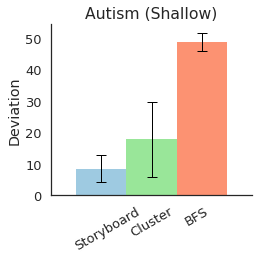

In [192]:
result = compute_prediction_distances("Prediction1(Autism).csv","Autism1")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Autism (Shallow)",
          yErrs=list(result["SD"].values/2.), ytitle="Deviation", fixed_ylim=False, rotation=30,
          autolabel_flag =False, filename="Autism1")

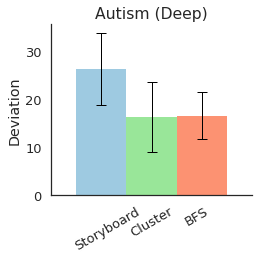

In [193]:
result = compute_prediction_distances("Prediction2(Autism).csv","Autism2")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Autism (Deep)",
          yErrs=list(result["SD"].values/2.),  ytitle="Deviation",fixed_ylim=False, rotation=30,
          autolabel_flag =False, filename="Autism2")

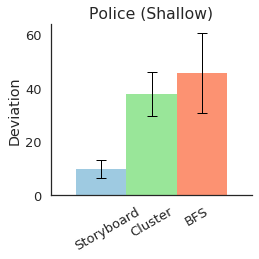

In [194]:
result = compute_prediction_distances("Prediction1(Police).csv","Police1")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Police (Shallow)",
          yErrs=list(result["SD"].values/2.), ytitle="Deviation"
          ,fixed_ylim=False , filename="Police1",autolabel_flag=False, rotation=30)

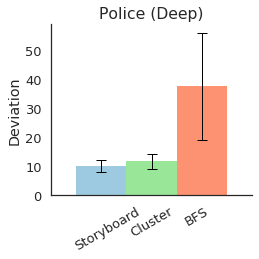

In [195]:
result = compute_prediction_distances("Prediction2(Police).csv","Police2")
bar_chart(list(result["Distance"].values),["Storyboard","Cluster","BFS"],title="Police (Deep)",
          yErrs=list(result["SD"].values/2.), ytitle="Deviation", rotation=30,fixed_ylim=False,
          filename="Police2",autolabel_flag=False)

In [75]:
def compute_prediction_aggregate_stats(title,filename,gt_task_key):
    prediction = pd.read_csv(gdrive_path+filename)
    if "Police" in filename: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    prediction = prediction.merge(user_task).drop("Note",axis=1)
    prediction_groupby=prediction.groupby(task_name)

    result = prediction_groupby.mean().reset_index()
    std_result = prediction_groupby.apply(lambda x: x.std()).reset_index()
    return result,std_result

In [86]:
def plot_prediction_results(result,std_result,xtitle="", ytitle="", title="", top_right_text="", N=1, width=0.1,autolabel_flag =True,fixed_ylim=False):
    task_name = ""
    fig, ax = plt.subplots()
    col = 0
    x0_lst =[]
    if "Police" in title: 
        attributes = ["ticket","warn","arrest"]
        task_name = "Task1"
    else: 
        attributes = ["NO","YES"]
        task_name = "Task2"
    labels = result[task_name].values
    for attr in attributes:
        ind = np.arange(N)  # the x locations for the groups
        x0= (col)*(ind + (2+0.5) * width + 0.1)
        x0_lst.append(x0[0])
        yVals = result[attr].values
        xAttrs = attributes
        yErrs = std_result[attr].values/2.

        if len(yVals)==2:
            colors = ["#fc9272","#9ecae1"]
            sns.set_palette(sns.color_palette(colors))
        else:
            colors = ["#9ecae1","#99e699","#fc9272"]
            sns.set_palette(sns.color_palette(colors))

        rects = []
        error_kw=dict(lw=1, capsize=5, capthick=1)
        for i in range(len(yVals)):
            if col==0:
                if yErrs==[]:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width,label=labels[i])
                else:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw,label=labels[i])
            else:
                if yErrs==[]:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width)
                else:
                    rect = ax.bar(x0+ind + (i+0.5) * width, yVals[i], width, ecolor="black",yerr=yErrs[i],error_kw=error_kw)
            rects.append(rect)

        xtitle = xtitle.replace('"', '')
        ytitle = ytitle.replace('"', '')

        ax.set_xlabel(xtitle)
        ax.set_ylabel(ytitle)
        if title != "":
            title = title.replace('"','')
            title = title.replace("#", ",\n")
            if title[0] == ',':
                title = title[2:-2]
            if title.count(',') < 3:
                ax.set_title(title)
            else:
                ax.set_title(title)
        xmin = -0.05
        xmax = 0.25 + 0.1 * (len(yVals) - 2)
        xtickpos = [np.abs(xmin - xmax) / (len(yVals) + 1.5) * (i + 0.7) for i in range(len(yVals))]
        if "Police" in title: 
            xtickpos=[0.15,0.51,0.83]
        else: 
            xtickpos=[0.14,0.48]
        ax.set_xticks(xtickpos)
        ax.set_xticklabels(xAttrs)

        if fixed_ylim: ax.set_ylim((0, 100))
        size = 0
        for rect in rects:
            size += 1
        sns.despine(top=True, right=True)
        col+=1
    for col_i in range(len(attributes)):
        if "Police" in title: 
            if col_i==0:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1*width,xtickpos[col_i]+1.5*width, linestyle=":",linewidth=2, color='r',label="ground truth")
            else:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-1.5*width,xtickpos[col_i]+1.25*width, linestyle=":",linewidth=2, color='r')
        else:
            if col_i==0:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]-0.8*width,xtickpos[col_i]+3.3*width, linestyle=":",linewidth=2, color='r',label="ground truth")
            else:
                ax.axhline(prediction_ground_truth[gt_task_key][col_i],xtickpos[col_i]+0.5*width,xtickpos[col_i]+4.8*width, linestyle=":",linewidth=2, color='r')

    plt.tight_layout()
    plt.ylabel(ytitle)
    lgd = plt.legend(numpoints=1, loc="center right", bbox_to_anchor=(1.8, 0.5))
    plt.savefig("{}.pdf".format(title), bbox_extra_artists=(lgd,),bbox_inches='tight')
    plt.show()

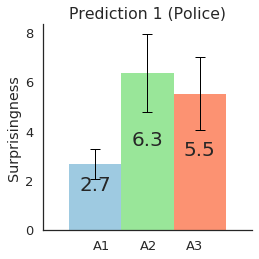

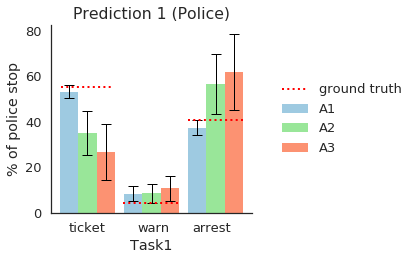

In [87]:
title="Prediction 1 (Police)"
filename = "Prediction1(Police).csv"
gt_task_key="Police1"
task_name = 'Task1'
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,task_name,title=title,ytitle="% of police stop")

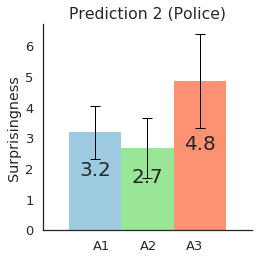

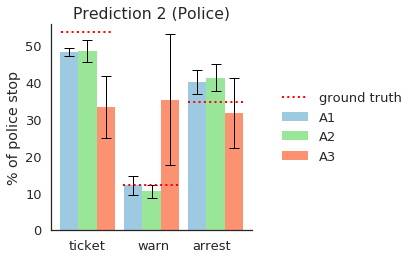

In [88]:
title="Prediction 2 (Police)"
filename = "Prediction2(Police).csv"
gt_task_key="Police2"
task_name = "Task1"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title,ytitle="% of police stop")

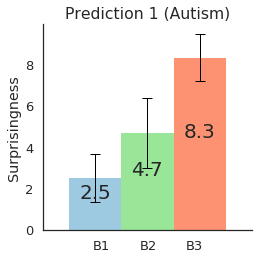

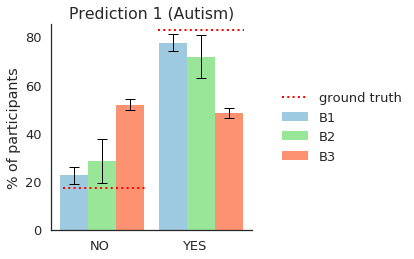

In [83]:
title="Prediction 1 (Autism)"
filename = "Prediction1(Autism).csv"
gt_task_key="Autism1"
task_name = "Task2"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title,ytitle="% of participants")

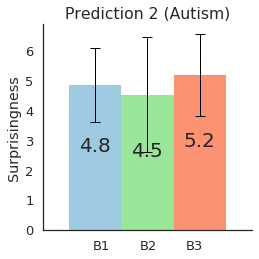

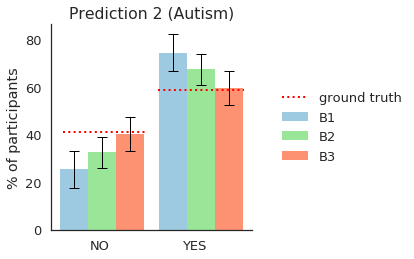

In [84]:
title="Prediction 2 (Autism)"
filename = "Prediction2(Autism).csv"
gt_task_key="Autism2"
task_name = "Task2"
result,std_result = compute_prediction_aggregate_stats(title,filename,gt_task_key)
#Surprisingness Plot
bar_chart(list(result["Surprisingness"].values),list(result[task_name].values),list(std_result["Surprisingness"].values/2.),title=title, ytitle="Surprisingness",fixed_ylim=False)
plot_prediction_results(result,std_result,title=title,ytitle="% of participants")

# Qualitative Analysis

In [81]:
police_code = pd.read_csv(gdrive_path+"Findings(Police).csv").replace("T",1).replace("F",0)
autism_code = pd.read_csv(gdrive_path+"Findings(Autism).csv").replace("T",1).replace("F",0)
police_code.columns=["User"]+list(user_task["Task1"])
autism_code.columns=["User"]+list(user_task["Task2"])
police_code=police_code.T.reset_index()
autism_code=autism_code.T.reset_index()
police_code.columns=police_code.loc[0]
police_code = police_code.drop(0)
autism_code.columns=autism_code.loc[0]
autism_code = autism_code.drop(0)

In [85]:
police_code.groupby("User",as_index=False).sum()

,User,"Overall, ticketing resulted in the highest arrest rate",duration and search conducted is probably correlated,"Only search_conducted, and duration 30+ are all important factors in determining arrest",Race is important because Black and Hispanic are arrested at higher rates than White,"contraband_found and search_conducted have simmilar distribution, which may mean that doesn't matter if contraband was found or not, outcomes are similar.",What's pulling up the arrest rate for 30+ min cases? Is race related to this or no?,Interesting that contraband found for 60+ arrest rate actually increases,confused that the middle path and rightmost path had different “splits” on variables (age/race) v.s. different races,"Population is majority white, so it should follow closely to immediate parent (contraband_found=t)",Gender does not seem to influence arrest rate. (based on combination or first level viz insight),Selected visualization with many filters are interesting 100% but may be high due to unknown subpopulation size and should be investigated further .,DId not understand that some chart may have a smaller subpopulation size,"Had trouble interpreting meaning of combination of filters, related to above.",Described dashboard as picked by a human,Comparing against other visualizations that have the one or more of the same attribute (relatives),Comparing against overall,Comparing against immediate parent,Comparing between siblings
0,A1,4,0,0,0,2,2,2,2,1,0,4,0,0,3,0,6,6,5
1,A2,4,3,5,0,0,0,0,0,3,1,3,1,2,0,6,5,2,0
2,A3,2,1,0,2,0,1,0,0,0,4,1,1,1,0,1,3,2,3


In [86]:
autism_code.groupby("User",as_index=False).sum()

,User,all the 0s have high skew towards NO and all 1s have about equal rates of YES and NO autism.,a9=1 is important,The overall is biased towards people who are taking this test.,the questions become better predictors as the question number increase.,The distribution reverses for every level in the tree.,Learned about overall population distribution,Selected visualization with many filters are interesting 100% but may be high due to unknown subpopulation size and should be investigated further .,Did not understand that some chart may have a smaller subpopulation size,"Had trouble interpreting meaning of combination of filters, related to above.",Described dashboard as picked by a human,Comparing against other visualizations that have the one or more of the same attribute (relatives),Comparing against overall,Comparing against immediate parent,Comparing between siblings
0,B1,2,4,1,0,6,3,2,1,0,2,0,5,6,3
1,B2,0,4,0,0,0,2,1,3,1,0,1,3,2,0
2,B3,4,2,1,1,0,3,2,0,0,1,2,5,2,2


In [88]:
police_code

,User,"Overall, ticketing resulted in the highest arrest rate",duration and search conducted is probably correlated,"search_conducted, contraband_found, and duration 30+ are all important factors in determining arrest","Only search_conducted, and duration 30+ are all important factors in determining arrest",Race is important because Black and Hispanic are arrested at higher rates than White,"contraband_found and search_conducted have simmilar distribution, which may mean that doesn't matter if contraband was found or not, outcomes are similar.",What's pulling up the arrest rate for 30+ min cases? Is race related to this or no?,Interesting that contraband found for 60+ arrest rate actually increases,confused that the middle path and rightmost path had different “splits” on variables (age/race) v.s. different races,"Population is majority white, so it should follow closely to immediate parent (contraband_found=t)",Gender does not seem to influence arrest rate. (based on combination or first level viz insight),Selected visualization with many filters are interesting 100% but may be high due to unknown subpopulation size and should be investigated further .,DId not understand that some chart may have a smaller subpopulation size,"Had trouble interpreting meaning of combination of filters, related to above.",Described dashboard as picked by a human,Comparing against other visualizations that have the one or more of the same attribute (relatives),Comparing against overall,Comparing against immediate parent,Comparing between siblings
1,A1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,1,1,1
2,A1,1,0,1,0,0,0,0,1,1,1,0,1,0,0,1,0,1,1,1
3,A2,1,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1,1,0
4,A2,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
5,A3,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1
6,A3,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0
7,A1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1
8,A1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1
9,A2,1,1,F,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
10,A2,1,0,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,1,0


In [87]:
autism_code

,User,all the 0s have high skew towards NO and all 1s have about equal rates of YES and NO autism.,a9=1 is important,The overall is biased towards people who are taking this test.,the questions become better predictors as the question number increase.,The distribution reverses for every level in the tree.,Learned about overall population distribution,Selected visualization with many filters are interesting 100% but may be high due to unknown subpopulation size and should be investigated further .,Did not understand that some chart may have a smaller subpopulation size,"Had trouble interpreting meaning of combination of filters, related to above.",Described dashboard as picked by a human,Comparing against other visualizations that have the one or more of the same attribute (relatives),Comparing against overall,Comparing against immediate parent,Comparing between siblings
1,B2,0,0,0,0,0,1,0,1,0,0,1,1,1,0
2,B3,1,0,1,1,0,1,0,0,0,1,1,1,1,1
3,B1,1,0,1,0,1,1,0,1,0,0,0,1,1,1
4,B3,1,0,0,0,0,1,1,0,0,0,0,1,0,0
5,B1,1,1,0,0,1,1,1,0,0,1,0,1,1,1
6,B2,0,0,0,0,0,0,0,1,1,0,0,0,0,0
7,B2,0,1,0,0,0,1,1,0,0,0,0,0,1,0
8,B3,1,0,0,0,0,0,0,0,0,0,0,1,1,1
9,B1,0,0,0,0,1,1,1,0,0,1,0,1,1,0
10,B3,1,0,0,0,0,1,1,0,0,0,1,1,0,0
